### **Actuarial Project**

#### **Phase Two: Frequency Model**

In [ ]:
# Installing & Importing Python packages
!pip -q install statsmodels

import pandas as pd                                              # For data manipulation and analysis
import numpy as np                                               # For numerical operations
import seaborn as sns                                            # For data visualization
import matplotlib.pyplot as plt                                  # For creating visualizations
import statsmodels.api as sm                                     # For statistical modeling
from sklearn.model_selection import train_test_split             # For splitting data into training and testing sets

# To ignore warnings
import warnings                                                  # To handle warnings
warnings.filterwarnings("ignore")                                # Suppress all warnings

In [ ]:
# Import dataset
insurance_data = pd.read_csv('/content/drive/MyDrive/Actuarial Project/model_ready_insurance_data.csv')

insurance_data.head()

,Age,Is_Senior,Marital_Status,Married_Premium_Discount,Prior_Insurance,Prior_Insurance_Premium_Adjustment,Claims_Frequency,Claims_Severity,Claims_Adjustment,Policy_Type,...,Region,Premium_Adjustment_Region,Risk_Tier,Loyalty_Band,Engagement_Score,Engagement_Level,Source_of_Lead_Agent,Source_of_Lead_Referral,Region_Urban,Region_Suburban
0,47,0,1,86,1,50,0,0,0,1,...,Suburban,50,0,1,13,1,1,0,0,1
1,37,0,1,86,1,50,0,0,0,1,...,Urban,100,0,1,13,1,0,0,1,0
2,49,0,1,86,1,50,1,0,50,1,...,Urban,100,0,1,15,1,0,0,1,0
3,62,1,1,86,2,0,1,0,50,1,...,Urban,100,0,2,16,2,0,0,1,0
4,36,0,0,0,2,0,2,0,100,1,...,Suburban,50,1,2,22,2,1,0,0,1


#### **modelling target & features (risk factors only)**

the frequency GLM should use intrinsic risk factors (age, region, tier, etc.).
We’ll exclude commercial/pricing outcomes and operational adjustments (e.g., Premium_Amount, Conversion_Status, Policy_Adjustment, Premium_Adjustment_*, Time_Since_First_Contact, funnel counters), so we don’t bake sales/price effects into risk.

In [ ]:
TARGET = "Claims_Frequency"

candidate_features = [
    # numerics / ordinals
    "Age",
    "Risk_Tier",        # 0/1/2 (Low/Med/High)
    "Loyalty_Band",     # 0/1/2 (New/1-5/>5) — OK to include if your book mixes new & renewals
    "Engagement_Score",
    "Credit_Score",

    # binaries we encoded
    "Is_Senior",            # 0/1
    "Marital_Status",       # 0/1 (1=Married)
    "Prior_Insurance",      # 0/1/2 (ordered: <1, 1-5, >5)
    "Policy_Type",          # 0/1 (1=Full Coverage)
    "Safe_Driver_Discount", # 0/1
    "Multi_Policy_Discount",# 0/1
    "Bundling_Discount",    # 0/1

    # region dummies (baseline = Rural)
    "Region_Urban",
    "Region_Suburban",
]

# We keep only columns that are required.
FEATURES = [c for c in candidate_features if c in insurance_data.columns]
print("Using features:", FEATURES)


Using features: ['Age', 'Risk_Tier', 'Loyalty_Band', 'Engagement_Score', 'Credit_Score', 'Is_Senior', 'Marital_Status', 'Prior_Insurance', 'Policy_Type', 'Safe_Driver_Discount', 'Multi_Policy_Discount', 'Bundling_Discount', 'Region_Urban', 'Region_Suburban']


#### **Train/validation split**

In [ ]:
df = insurance_data.copy()

train, test = train_test_split(df, test_size=0.25, random_state=42)

X_train = train[FEATURES].copy()
y_train = train[TARGET].astype(int).copy()

X_test  = test[FEATURES].copy()
y_test  = test[TARGET].astype(int).copy()

# Add intercept manually to statmodel
X_train = sm.add_constant(X_train, has_constant='add')
X_test  = sm.add_constant(X_test,  has_constant='add')

#### **Fit a Poisson GLM**

In [ ]:
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson())
poisson_res   = poisson_model.fit()
print(poisson_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       Claims_Frequency   No. Observations:                 7500
Model:                            GLM   Df Residuals:                     7486
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6592.0
Date:                Wed, 05 Nov 2025   Deviance:                       7014.3
Time:                        13:32:04   Pearson chi2:                 6.30e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.07847
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.83

#### **Interpret results**

In [ ]:
coefs = poisson_res.params.rename("coef")
relativities = np.exp(coefs).rename("relativity")
pd.concat([coefs, relativities], axis=1).sort_values("relativity", ascending=False).head(20)

,coef,relativity
Risk_Tier,0.532503,1.703190
Region_Suburban,0.073958,1.076762
Region_Urban,0.047277,1.048412
Multi_Policy_Discount,0.030370,1.030836
Prior_Insurance,0.013453,1.013543
Loyalty_Band,0.013453,1.013543
Marital_Status,0.008577,1.008614
Safe_Driver_Discount,0.001602,1.001603
Age,0.000009,1.000009
Credit_Score,-0.000345,0.999655


#### **Check over-dispersion (variance >> mean?)**

In [ ]:
def dispersion_stat(result):
    # Pearson chi2 / df_resid
    pearson_chi2 = sum(result.resid_pearson**2)
    return pearson_chi2 / result.df_resid

dispersion = dispersion_stat(poisson_res)
print("Dispersion (≈1 good, >1 over-dispersed):", round(dispersion, 3))


Dispersion (≈1 good, >1 over-dispersed): 0.842


#### **Predictions & quick validation**

In [ ]:
# Final model object
final_res = poisson_res   # since dispersion < 1.5

test_pred = final_res.predict(X_test)

#### Build a calibration table (Observed vs Predicted by Risk Decile)

In [ ]:
# Create comparison DataFrame
test_df = pd.DataFrame({
    "Observed": y_test.values,
    "Predicted": test_pred.values
})

# Create deciles based on predicted frequency
test_df["Decile"] = pd.qcut(test_df["Predicted"].rank(method="first"), 10, labels=False)

# Summarize observed and predicted by decile
calibration = (
    test_df.groupby("Decile")
           .agg(
               Avg_Predicted=("Predicted", "mean"),
               Avg_Observed =("Observed", "mean"),
               Exposure     =("Observed", "size")
           )
           .reset_index()
)

calibration



,Decile,Avg_Predicted,Avg_Observed,Exposure
0,0,0.330380,0.404,250
1,1,0.342626,0.368,250
2,2,0.349900,0.328,250
3,3,0.356215,0.324,250
4,4,0.363054,0.352,250
5,5,0.372806,0.332,250
6,6,0.544750,0.776,250
7,7,0.601310,0.776,250
8,8,0.685588,0.800,250
9,9,1.035496,0.804,250


#### **Turning coefficients into a rating view**

In [ ]:
rel = np.exp(final_res.params).rename("Relativity").to_frame()
rel.index.name = "Factor"
rel.reset_index().sort_values("Relativity", ascending=False).head(25)


,Factor,Relativity
2,Risk_Tier,1.703190
14,Region_Suburban,1.076762
13,Region_Urban,1.048412
11,Multi_Policy_Discount,1.030836
8,Prior_Insurance,1.013543
3,Loyalty_Band,1.013543
7,Marital_Status,1.008614
10,Safe_Driver_Discount,1.001603
1,Age,1.000009
5,Credit_Score,0.999655


#### **Plot Observed vs Predicted**

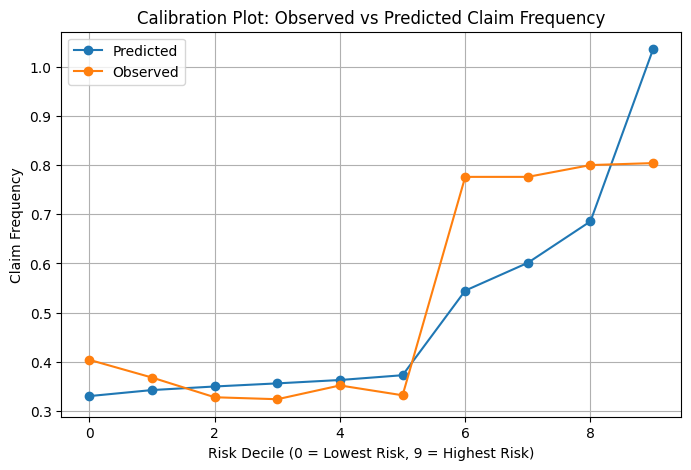

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(calibration["Decile"], calibration["Avg_Predicted"], marker='o', label="Predicted")
plt.plot(calibration["Decile"], calibration["Avg_Observed"],  marker='o', label="Observed")
plt.xlabel("Risk Decile (0 = Lowest Risk, 9 = Highest Risk)")
plt.ylabel("Claim Frequency")
plt.title("Calibration Plot: Observed vs Predicted Claim Frequency")
plt.legend()
plt.grid(True)
plt.show()


#### **Add Expected Frequency into the original dataset**

In [ ]:
insurance_data["Expected_Claim_Freq"] = poisson_res.predict(
    sm.add_constant(insurance_data[FEATURES], has_constant='add')
)

insurance_data.to_csv('/content/drive/MyDrive/Actuarial Project/model_ready_insurance_data.csv', index=False)


In [ ]:
insurance_data.head()


,Age,Is_Senior,Marital_Status,Married_Premium_Discount,Prior_Insurance,Prior_Insurance_Premium_Adjustment,Claims_Frequency,Claims_Severity,Claims_Adjustment,Policy_Type,...,Premium_Adjustment_Region,Risk_Tier,Loyalty_Band,Engagement_Score,Engagement_Level,Source_of_Lead_Agent,Source_of_Lead_Referral,Region_Urban,Region_Suburban,Expected_Claim_Freq
0,47,0,1,86,1,50,0,0,0,1,...,50,0,1,13,1,1,0,0,1,0.363514
1,37,0,1,86,1,50,0,0,0,1,...,100,0,1,13,1,0,0,1,0,0.351234
2,49,0,1,86,1,50,1,0,50,1,...,100,0,1,15,1,0,0,1,0,0.344120
3,62,1,1,86,2,0,1,0,50,1,...,100,0,2,16,2,0,0,1,0,0.338698
4,36,0,0,0,2,0,2,0,100,1,...,50,1,2,22,2,1,0,0,1,0.626310
